In [4]:
from GraphModels.model import *
from GraphModels.solvers import *
from GraphModels.metrics import *
import networkx as nx
import matplotlib.pyplot as plt
import random
from experiments import *
import pickle

from scipy.optimize import curve_fit
import scipy as sc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def f(x, a, b, c):
    return a * np.power(x, b) + c

params = curve_fit(f, np.arange(0.1, 1, 0.1), [0.94, 0.87, 0.85, 0.77, 0.74, 0.68, 0.64, 0.55, 0.4])[0]

In [7]:
N = 20
n = 40
S_exp = 10
S_obs = 2

solver = MHTSolver(0.05, pcorr_pvalues, pcorrcoef)

data = [familywise_MHT_experiments(CholPCorrModel, solver, N, f(dens, *params), n, S_exp, S_obs, [TN, FN, FP, TP], verbose=True) for dens in np.arange(0.1, 1, 0.1)]
data = np.stack(data)

data.shape

Family-wise MHT experiment with 0.913 completed in time: 2.364s
Family-wise MHT experiment with 0.887 completed in time: 2.123s
Family-wise MHT experiment with 0.85 completed in time: 1.861s
Family-wise MHT experiment with 0.802 completed in time: 2.021s
Family-wise MHT experiment with 0.745 completed in time: 3.505s
Family-wise MHT experiment with 0.68 completed in time: 2.746s
Family-wise MHT experiment with 0.606 completed in time: 2.365s
Family-wise MHT experiment with 0.523 completed in time: 2.391s
Family-wise MHT experiment with 0.434 completed in time: 2.169s


(9, 10, 2, 4, 5)

In [ ]:
with open('experiment_data.bin', 'wb') as f:
    pickle.dump(data, f)

In [31]:
with open('experimentFechner300.bin', 'rb') as f:
    data = pickle.load(f)

In [32]:
data.shape

(9, 1000, 200, 4, 5)

In [33]:
exp_combined = data.reshape((9, -1, 4, 5))

exp_combined.shape

(9, 200000, 4, 5)

In [34]:
fdr_c, fomr_c, tnr_c, tpr_c = [], [], [], []
bacc_c, f1_c, mcc_c = [], [], []

for i in range(9):
    tns = exp_combined[i, :, 0, :]
    fns = exp_combined[i, :, 1, :]
    fps = exp_combined[i, :, 2, :]
    tps = exp_combined[i, :, 3, :]

    tnr = tns / (fps + tns)
    tpr = tps / (fns + tps)
    fdr = fps / (fps + tps)
    fomr = fns / (fns + tns)

    fdr_f = np.nan_to_num(fdr)
    fomr_f = np.nan_to_num(fomr)
    tnr_f = np.nan_to_num(tnr, nan=1)
    tpr_f = np.nan_to_num(tpr, nan=1)

    bacc = (tpr + tnr) / 2
    f1 = hmean([1 - fdr_f, tpr_f], axis=0)

    mcc_first = tpr_f * tnr_f * (1 - fdr_f) * (1 - fomr_f)
    mcc_second = (1 - tpr_f) * (1 - tnr_f) * fomr_f * fdr_f
    mcc = np.sqrt(mcc_first) - np.sqrt(mcc_second)

    fdr_c.append(fdr_f.mean(axis=0))
    fomr_c.append(fomr_f.mean(axis=0))
    tnr_c.append(tnr_f.mean(axis=0))
    tpr_c.append(tpr_f.mean(axis=0))

    bacc_c.append(bacc.mean(axis=0))
    f1_c.append(f1.mean(axis=0))
    mcc_c.append(mcc.mean(axis=0))

fdr_c, fomr_c, tnr_c, tpr_c = np.stack(fdr_c), np.stack(fomr_c), np.stack(tnr_c), np.stack(tpr_c)
bacc_c, f1_c, mcc_c = np.stack(bacc_c), np.stack(f1_c), np.stack(mcc_c)

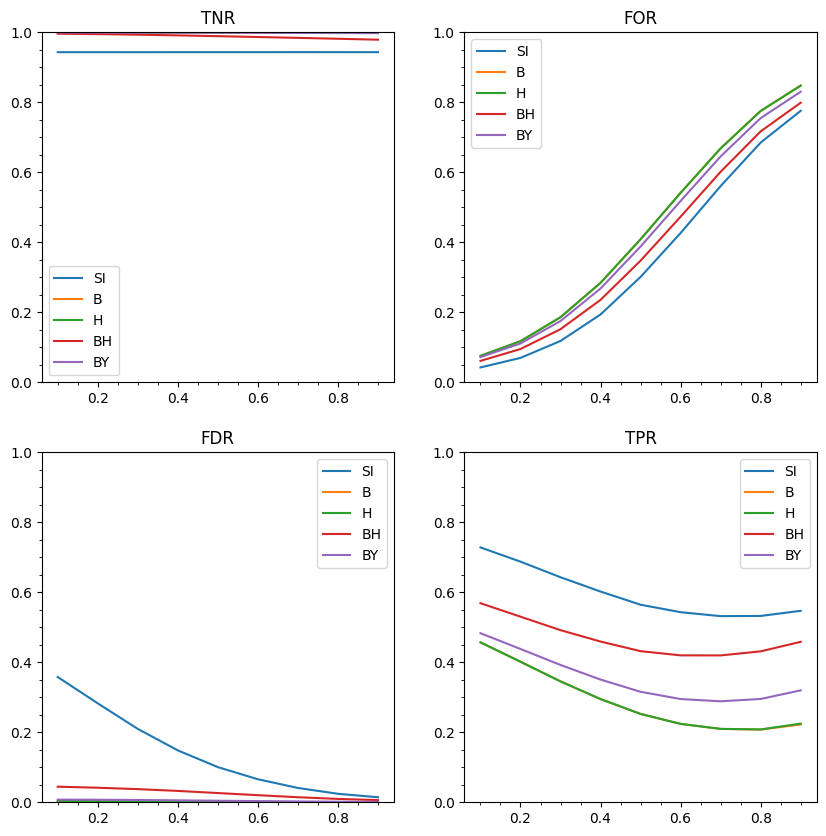

In [35]:
density_list = np.arange(0.1, 1, 0.1)

plt.subplot(2, 2, 1)
plt.plot(density_list, tnr_c[:, 0], label='SI')
plt.plot(density_list, tnr_c[:, 1], label='B')
plt.plot(density_list, tnr_c[:, 2], label='H')
plt.plot(density_list, tnr_c[:, 3], label='BH')
plt.plot(density_list, tnr_c[:, 4], label='BY')
plt.title('TNR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(density_list, fomr_c[:, 0], label='SI')
plt.plot(density_list, fomr_c[:, 1], label='B')
plt.plot(density_list, fomr_c[:, 2], label='H')
plt.plot(density_list, fomr_c[:, 3], label='BH')
plt.plot(density_list, fomr_c[:, 4], label='BY')
plt.title('FOR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(density_list, fdr_c[:, 0], label='SI')
plt.plot(density_list, fdr_c[:, 1], label='B')
plt.plot(density_list, fdr_c[:, 2], label='H')
plt.plot(density_list, fdr_c[:, 3], label='BH')
plt.plot(density_list, fdr_c[:, 4], label='BY')
plt.title('FDR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(density_list, tpr_c[:, 0], label='SI')
plt.plot(density_list, tpr_c[:, 1], label='B')
plt.plot(density_list, tpr_c[:, 2], label='H')
plt.plot(density_list, tpr_c[:, 3], label='BH')
plt.plot(density_list, tpr_c[:, 4], label='BY')
plt.title('TPR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()
plt.gcf().set_size_inches((10, 10))
plt.show()

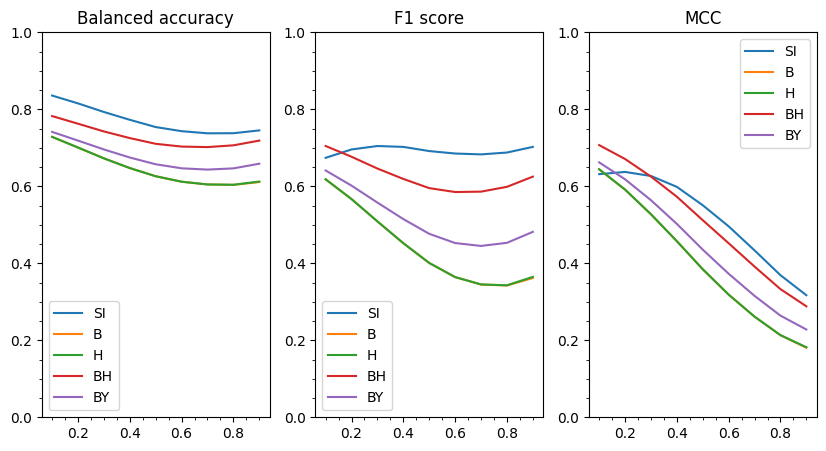

In [36]:
plt.subplot(1, 3, 1)
plt.plot(density_list, bacc_c[:, 0], label='SI')
plt.plot(density_list, bacc_c[:, 1], label='B')
plt.plot(density_list, bacc_c[:, 2], label='H')
plt.plot(density_list, bacc_c[:, 3], label='BH')
plt.plot(density_list, bacc_c[:, 4], label='BY')
plt.title('Balanced accuracy')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(density_list, f1_c[:, 0], label='SI')
plt.plot(density_list, f1_c[:, 1], label='B')
plt.plot(density_list, f1_c[:, 2], label='H')
plt.plot(density_list, f1_c[:, 3], label='BH')
plt.plot(density_list, f1_c[:, 4], label='BY')
plt.title('F1 score')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(density_list, mcc_c[:, 0], label='SI')
plt.plot(density_list, mcc_c[:, 1], label='B')
plt.plot(density_list, mcc_c[:, 2], label='H')
plt.plot(density_list, mcc_c[:, 3], label='BH')
plt.plot(density_list, mcc_c[:, 4], label='BY')
plt.title('MCC')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.gcf().set_size_inches((10, 5))
plt.show()

In [21]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [5]:
mod = CholCorrModel(5, 0.95)
data = mod.sample(1000, dist=sc.stats.multivariate_t, df=3)
slv = MHTSolver(0.05, fechner_pvalues, fechnercoef)
slv.fit(data)

In [6]:
data

array([[-0.53021358, -0.63872688,  0.25890603,  0.62511242,  0.72654413],
       [ 1.22974087, -1.55514935, -1.0575255 ,  1.05440198,  0.40949774],
       [-0.54150595,  0.20118117, -2.8928004 ,  0.00646789, -0.2568208 ],
       ...,
       [-0.75674373, -1.64001419, -0.24183656, -1.39360033,  0.6592306 ],
       [-1.79405892, -0.65510241, -0.94425401,  3.19508727,  0.94401117],
       [-1.00424529,  0.85769133, -0.29811105,  0.32924696,  0.70931523]])